# **Diagnosing Pneumonia using AI: A Convolution Neural Network Model from Chest X-Ray Images**


This report contains a detailed explanation of the extraction, exploration, data preparation and generation of deep learning models for the diagnosis of pneumonia from chest x-ray images. 






## **I. Overview and Goals**

Pneumonia is an inflammatory condition of the lung usually caused by infection with viruses or bacteria. Typically symptoms include some combination of productive or dry cough, chest pain, fever, and trouble breathing. Severity is variable, but in severe cases or cases that go undiagnosed pneumonia can cause death. In fact, each year, pneumonia affects about 450 million people globally (7% of the population) and results in about 4 million deaths. However, cases, if the disease is diagnosed and treated in its early stages, pneumonia is largely treatable. Therefore, it is critical to develop better tools that can streamline and improve the diagnosis of pneumonia. The ultimate goal of this project is to build an artificial intelligence model that can be used in clinical settings to diagnose pneumonia and thus improve the efficiency of the healthcare system. 


To be able to better understand this problem and how to solve it, I have divisided this analysis into three questions:

1) Can we distinguish healthy versus pneumonia patients solely by chest x-ray imaging?

2) Can we accuratly predict the diagnosis of pneumonia from chest x-ray images?

3) What x-ray features contribute the most for the incorrect diagnosis of a patient?

## **II. Data Understanding and Preparation**

The dataset used in this analysis/model is available on Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and contains a total number of 5863 chest x-ray images from either healthy (normal) or patients diagnosed with pneumonia (pneumonia). The dataset is comprised of three sub datasets: 

- Training dataset 

- Test dataset 

- Validation dataset 

In [ ]:
# Import libraries

import os, sys, glob
import numpy as np
np.random.seed(123)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install lime

     |████████████████████████████████| 276kB 4.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=12d36db144f4ffc567fe2229c59cd52487e6318ae92be4584600f2cbbbd6d9bc
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import tensorflow as tf
from sklearn import metrics
from keras import models
from keras.preprocessing import image
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import lime
from lime import lime_image
from lime import lime_base

from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
lime_image.LimeImageExplainer


lime.lime_image.LimeImageExplainer

In [ ]:
os.listdir()

['.config', 'sample_data']

In [ ]:
# Data Upload

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
file = "archive.zip"

zip_path = "/content/drive/MyDrive/"+ file
zip_path

'/content/drive/MyDrive/archive.zip'

In [ ]:
!cp "{zip_path}" .

!unzip -q "{file}" 
!rm "{file}" 

In [ ]:
ls

chest_xray/  drive/  sample_data/


In [ ]:
# Assign the data to the base folder
BASE_FOLDER = "chest_xray/"
os.makedirs(BASE_FOLDER,exist_ok=True)
os.listdir(BASE_FOLDER)

['chest_xray', 'val', 'test', 'train', '__MACOSX']

In [ ]:
## Specify the training folder and test folder
train_folder = BASE_FOLDER+"train/"
test_folder = BASE_FOLDER+"test/"
print(os.listdir(train_folder))

['NORMAL', 'PNEUMONIA']


## **III. Data Exploration**

Here we explore how many images are in each dataset and what class do they belong to

In [ ]:

for i in [train_folder, test_folder]:

    print(":::::::::: ", i[11:-1], " :::::::::::::::")
    pneumonia = len(os.listdir(os.path.join(i, "PNEUMONIA")))
    normal = len(os.listdir(os.path.join(i, "NORMAL")))
    print(f" Pneumonia =  {pneumonia}")
    print(f" Normal = {normal}")



::::::::::  train  :::::::::::::::
 Pneumonia =  3875
 Normal = 1341
::::::::::  test  :::::::::::::::
 Pneumonia =  390
 Normal = 234


In [ ]:
from glob import glob
n_images = glob(train_folder + '/NORMAL/*.jpeg')
p_images = glob(train_folder + '/PNEUMONIA/*.jpeg')
print(f"Class Imbalance: There are normal {len(n_images)} and {len(p_images)} Pneumania")

Class Imbalance: There are normal 1341 and 3875 Pneumania


Here is a count of the number of chest x-ray images ascribed to each diagnosis included in the training dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


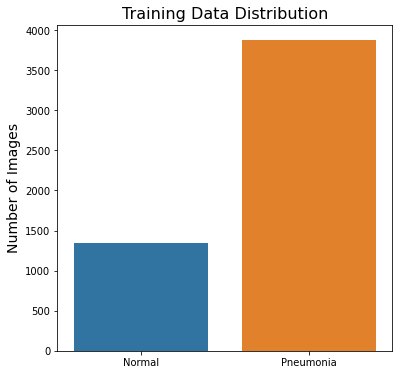

In [ ]:
# plot the training data distrubibution
plt.figure(figsize = (6,6))
sns.barplot(["Normal", "Pneumonia"], [len(n_images), len(p_images)])
plt.ylabel('Number of Images', fontsize = 14)
plt.title("Training Data Distribution", fontsize = 16);

Before diving into building a complex model capable of accuratly predicting pneumonia, it is important to understand how pneumonia is diagnosed. The most frequently used method to diagnose pneumonia is a chest x-ray. Here is how the chest x-ray images of healthy lungs looks like:

In [ ]:
import matplotlib.image as mpimg
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      plt.title(path[18:])
      plt.axis("off")
      imgplot = plt.imshow(img)

      amount += 1

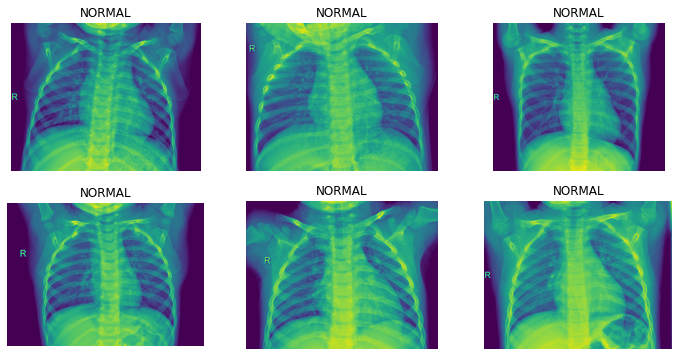

In [ ]:
plot_images(train_folder + '/NORMAL')

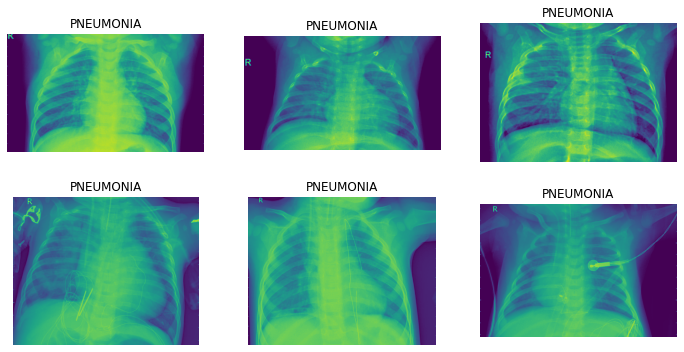

In [ ]:
plot_images(train_folder + '/PNEUMONIA', labeled= True)

When interpreting the x-ray, doctors look for white spots in the lungs (called infiltrates) that identify the infection. Looking at the x-ray images in our datasets we can see that chest x-rays of pneumonia patients show the presence of white spots and the general architecture of the lung is different than of healthy people. Thus, analysis of x-ray images are one of the most reliable ways to effectively diagnose pneumonia.

## **IV. Data Preparation for Modeling**

Because the data provided as the validation dataset only contained 16 images, I decided to randomly split the test dataset into data to validate my models (20% of the data corresponding to 124 x-ray images) and data to test my models (80% of the data corresponding to 500 x-ray images). 

To get the x-ray images ready for modeling, I have use the ImageDataGenerator class to load the data and prepare the data for modeling. This is very useful when handling large datasets as it allows for the images to be progressively loaded in batches from file, retrieving just enough data for what is needed immediately.

The constructor for the ImageDataGenerator contains many arguments to specify how to manipulate the image data after it is loaded, including pixel scaling and data augmentation. Thus, also allowing to not configurate the specific details about each image as it is loaded but also expand the training dataset with new, plausible examples. Using this class I scaled the array of pixels in the original images of all my datasets to pixel values between 0 and 1, which a range prefered for neural networks modeling. I also used data augmentation methods including rotation, width and height shifts and zoom to create variations of the training set images that are likely to be seen by the model. 

In addition, I also using the "flow_from_directory" method I also normalized the size of all the images to 64x64. I kept the batch size at 32 (the default size used) and used a binary classification as the datasets only contains two classes (pneumonia or normal).

In [ ]:
#Image Dataset Settings
VAL_SPLIT = 0.2 
IMG_SIZE = (64,64) 
BATCH_SIZE = 32

# Create ImageDataGenerator for training data 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10,      # randomly rotate image
                                   width_shift_range = 0.2,  #randomly shift image horizontal
                                   height_shift_range = 0.2,  #randomly shift image vertical
                                   zoom_range = 0.1          #randomly zoom image 
                                   )

# Create ImageDataaGenerator for validation and test data
test_val_datagen = ImageDataGenerator(rescale = 1./255,
                                      validation_split=VAL_SPLIT,
                                      )

In [ ]:
#Use generators flow_from_directory train_set
train_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size=IMG_SIZE,      #(height , width (64, 64)
                                                  batch_size=BATCH_SIZE,    #(size of th batches of data defult 32)
                                                  classes = ["NORMAL", "PNEUMONIA"],
                                                  class_mode='binary',
                                              shuffle=False
                                               
                                             )                                                  


# Makng a Test Set and validation set from the same folder.
test_set = test_val_datagen.flow_from_directory(test_folder,
                                                     target_size=IMG_SIZE,
                                                     subset='training',
                                                     batch_size=BATCH_SIZE,
                                                     classes = ["NORMAL", "PNEUMONIA"],
                                                     class_mode='binary',
                                                shuffle=False
                                               )

val_set = test_val_datagen.flow_from_directory(test_folder,target_size=IMG_SIZE,
                                                   subset='validation',
                                                    batch_size=BATCH_SIZE,
                                                    classes = ["NORMAL", "PNEUMONIA"],
                                                    class_mode='binary',
                                               shuffle=False
                                              )

Found 5216 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [ ]:
train_size = len(train_set.filenames)
val_size = len(val_set.filenames)
test_size = len(test_set.filenames)
train_size, val_size, test_size

(5216, 124, 500)

#### **Baseline Model**

In [ ]:

#initialising the CNN 
model = models.Sequential()

#Add a convolution layer with 32 kernels of 3X3 shape padding of same and activation Relu
model.add(Conv2D(32, (3, 3),padding="same", activation='relu',input_shape=(64,  64, 3)))
# Add  Max Pooling layer
model.add(MaxPooling2D((2, 2)))

#Add a convolution layer with 64 kernels of 3X3 shape padding of same and activation Relu
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(3, 3))

model.add(Conv2D(64, (3, 3), padding="same",  activation='relu'))
model.add(MaxPooling2D((2, 2)))


#Flatting the layer before fully connected layers
model.add(Flatten())

#Add a fully connected layer with 256 neurons

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [ ]:
history = model.fit_generator(train_set,
                       epochs= 10,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 67s 315ms/step - loss: 0.7817 - acc: 0.7245 - val_loss: 1.6613 - val_acc: 0.5208
Epoch 2/10
163/163 [==============================] - 51s 311ms/step - loss: 0.6410 - acc: 0.7498 - val_loss: 0.8157 - val_acc: 0.4792
Epoch 3/10
163/163 [==============================] - 51s 312ms/step - loss: 0.5673 - acc: 0.7412 - val_loss: 0.6259 - val_acc: 0.5625
Epoch 4/10
163/163 [==============================] - 51s 308ms/step - loss: 0.4642 - acc: 0.7933 - val_loss: 0.9125 - val_acc: 0.5521
Epoch 5/10
163/163 [==============================] - 51s 312ms/step - loss: 0.4336 - acc: 0.8035 - val_loss: 1.2642 - val_acc: 0.5521
Epoch 6/10
163/163 [==============================] - 51s 310ms/step - loss: 0.3946 - acc: 0.8372 - val_loss: 0.4541 - val_acc: 0.7604
Epoch 7/10
163/163 [==============================] - 51s 310ms/step - loss: 0.3397 - acc: 0.8549 - val_loss: 0.2298 - val_acc: 0.9062
Epoch 8/10
163/163 [==============================] - 5

In [ ]:
# Model evaluation

In [ ]:
def model_evaluate(model, history):
 
  train_loss = history.history["loss"]
  validation_loss = history.history["val_loss"]

  # train loss and validation loss
  train_accuracy = history.history["acc"]
  validation_accuracy = history.history["val_acc"]

  # line plot of train and validation loss
  fig , ax = plt.subplots(1,2, figsize=(12,8))
  #plt.figure(figsize=(10,8))

  ax[0].plot(train_accuracy, label= "Training Accuracy", color= "red")
  ax[0].plot(validation_accuracy, label= "Validation Accuracy", color= "blue")
  ax[0].legend(fontsize = 16)

  # line plot of train and validation loss

  ax[1].plot(train_loss, label= "Training Loss", color= "red")
  ax[1].plot(validation_loss, label= "Validation Loss", color= "blue")
  ax[1].legend(fontsize = 16)
  plt.show()

  print('***'*20)  
  print('Classification Report')
  print('***'*20) 

  predictions = model.predict_generator(generator=test_set,
                                        steps = test_size/BATCH_SIZE
                                        )


  #y_hat = np.where(predictions > 0.5, 1, 0)
  y_hat = (predictions > 0.5).astype(int)
  y_true = test_set.classes

  print(metrics.classification_report(y_true,y_hat, target_names=list(test_set.class_indices.keys())))

  cm = confusion_matrix(y_true, y_hat, normalize="true")

  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.2f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
  ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
  plt.show()

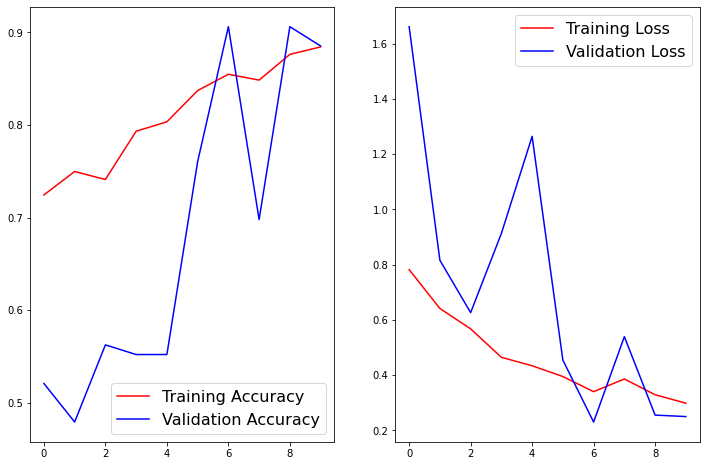

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.89      0.68      0.77       188
   PNEUMONIA       0.83      0.95      0.89       312

    accuracy                           0.85       500
   macro avg       0.86      0.81      0.83       500
weighted avg       0.85      0.85      0.84       500



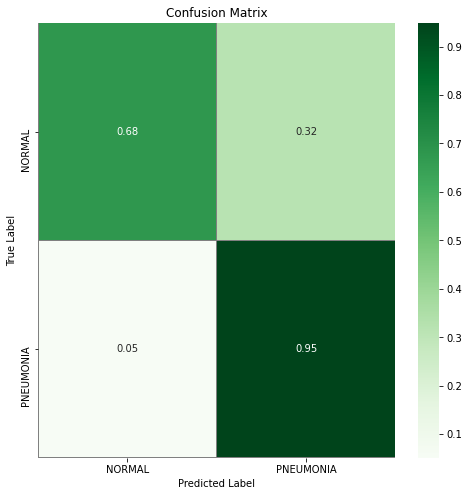

In [ ]:
model_evaluate(model, history)

Looking at this model, we can see that the accuracy is 85%, which is pretty good to start with, and has the ability to predict 95% of pneumonia cases. However, its ability to predict healthy x-rays is limited, resulting in a high false positive rate (32%).

### **Model 1**
In order to see if I could improve the baseline model, I added an additional convolution layer and fine-tuned the kernels within the different convolution layers. I also added an additional pooling layers and added 3 additional dense fully connected layers. 

In [ ]:
#initialising the CNN 
model_1 = models.Sequential()

#Add a convolution layer with 32 kernels of 3X3 shape padding of same and activation Relu
model_1.add(Conv2D(32, (3,3 ),padding="same", activation='relu',                
                    input_shape=(64,  64, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
# Add  Max Pooling layer
model_1.add(MaxPooling2D((2, 2)))


#Add a convolution layer with 128 kernels of 3X3 shape padding of same and activation Relu
model_1.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model_1.add(MaxPooling2D(2, 2))

model_1.add(Conv2D(128, (3, 3), padding="same",  activation='relu'))
model_1.add(MaxPooling2D((2, 2)))



model_1.add(Flatten())
#Add a fully connected layers
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(512, activation='relu'))

model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
history = model_1.fit_generator(train_set,
                       epochs= 10,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 52s 312ms/step - loss: 0.6908 - acc: 0.7318 - val_loss: 10.3727 - val_acc: 0.5208
Epoch 2/10
163/163 [==============================] - 50s 307ms/step - loss: 0.8125 - acc: 0.7343 - val_loss: 0.7635 - val_acc: 0.5208
Epoch 3/10
163/163 [==============================] - 50s 309ms/step - loss: 0.6032 - acc: 0.7393 - val_loss: 1.3786 - val_acc: 0.5000
Epoch 4/10
163/163 [==============================] - 51s 316ms/step - loss: 0.4984 - acc: 0.7799 - val_loss: 2.3887 - val_acc: 0.5417
Epoch 5/10
163/163 [==============================] - 50s 306ms/step - loss: 0.4862 - acc: 0.7947 - val_loss: 0.5892 - val_acc: 0.6458
Epoch 6/10
163/163 [==============================] - 50s 308ms/step - loss: 0.4290 - acc: 0.8334 - val_loss: 0.3713 - val_acc: 0.8021
Epoch 7/10
163/163 [==============================] - 50s 307ms/step - loss: 0.4410 - acc: 0.8558 - val_loss: 0.6032 - val_acc: 0.6146
Epoch 8/10
163/163 [==============================] - 

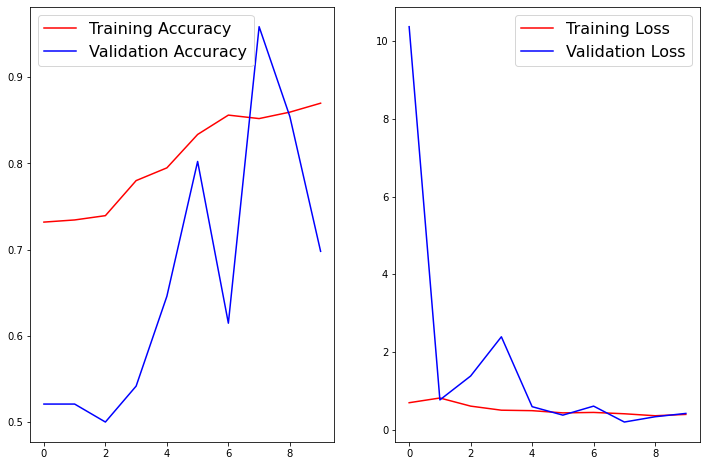

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.97      0.48      0.65       188
   PNEUMONIA       0.76      0.99      0.86       312

    accuracy                           0.80       500
   macro avg       0.86      0.74      0.75       500
weighted avg       0.84      0.80      0.78       500



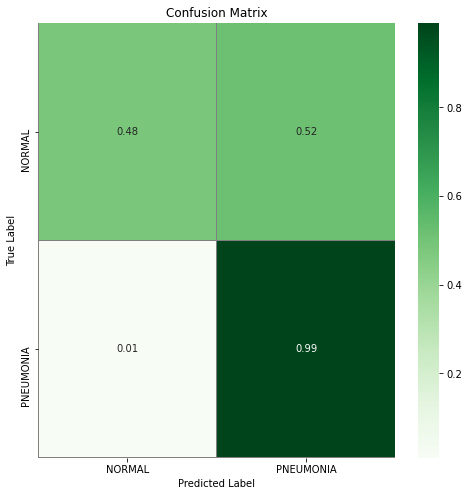

In [ ]:
model_evaluate(model_1, history)

Looking at the results of Model 1 we can see that the CNN architecture that I developed here actually had the opposite effect, as the model became less accurate (from 85% in the baseline model to 80% in this model). The ability to correctly predict pneumonia increased to 99%, however this model has an even harder time recalling normal x-rays with a false positive rate of 52%.

### **Model 2**
Because the changes I made in Model 1 did not improve the ability to accuratly predict the x-ray images, I decided to change a little bit the architecture of the CNN network. This time, I decided to  introduced two dropout layers. Dropout is a technique where randomly selected neurons are ignored during training. The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization. I added one dropout layer after the convolotion and pooling layers just before flatening the layers into a one dimensional array of features. In addition, I increased the number of dense fully connected layers to 5, and added another dropout layer between the second and the third dense fully connected layers.

In [ ]:
#initialising the CNN 
model_2 = models.Sequential()

#Add a convolution layer with 32 kernels of 3X3 shape padding of same and activation Relu
model_2.add(Conv2D(32, (3,3 ),padding="same", activation='relu',                
                    input_shape=(64,  64, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
# Add  Max Pooling layer
model_2.add(MaxPooling2D((2, 2)))


#Add a convolution layer with 128 kernels of 3X3 shape padding of same and activation Relu
model_2.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model_2.add(MaxPooling2D(2, 2))

model_2.add(Conv2D(128, (3, 3), padding="same",  activation='relu'))
model_2.add(MaxPooling2D((2, 2)))


#model_2.add(Dropout(0.2))
#Flatting the layer before fully connected layers
model_2.add(Flatten())
#Add a fully connected layers
#model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
history = model_2.fit_generator(train_set,
                       epochs= 10,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 52s 317ms/step - loss: 0.7535 - acc: 0.7375 - val_loss: 2.8385 - val_acc: 0.5208
Epoch 2/10
163/163 [==============================] - 50s 308ms/step - loss: 0.6796 - acc: 0.7416 - val_loss: 7.4437 - val_acc: 0.5208
Epoch 3/10
163/163 [==============================] - 51s 314ms/step - loss: 0.6529 - acc: 0.7490 - val_loss: 0.8210 - val_acc: 0.5208
Epoch 4/10
163/163 [==============================] - 51s 313ms/step - loss: 0.5328 - acc: 0.7510 - val_loss: 0.6166 - val_acc: 0.5938
Epoch 5/10
163/163 [==============================] - 51s 313ms/step - loss: 0.4698 - acc: 0.7972 - val_loss: 0.5138 - val_acc: 0.6667
Epoch 6/10
163/163 [==============================] - 52s 316ms/step - loss: 0.4335 - acc: 0.8223 - val_loss: 0.7815 - val_acc: 0.6042
Epoch 7/10
163/163 [==============================] - 51s 316ms/step - loss: 0.3972 - acc: 0.8499 - val_loss: 0.4163 - val_acc: 0.7812
Epoch 8/10
163/163 [==============================] - 5

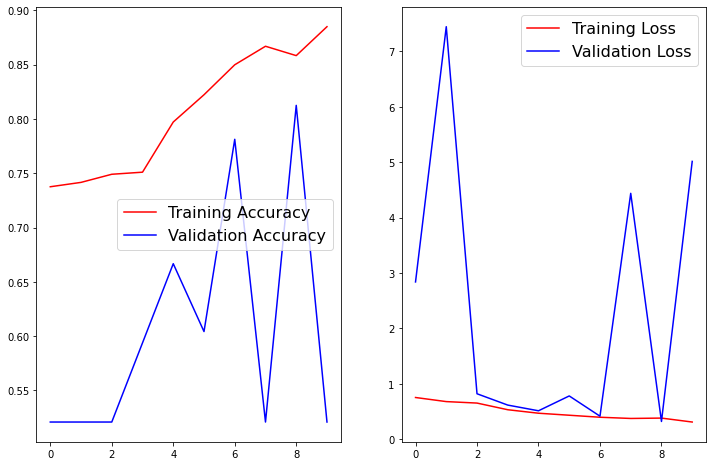

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       188
   PNEUMONIA       0.62      1.00      0.77       312

    accuracy                           0.62       500
   macro avg       0.31      0.50      0.38       500
weighted avg       0.39      0.62      0.48       500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


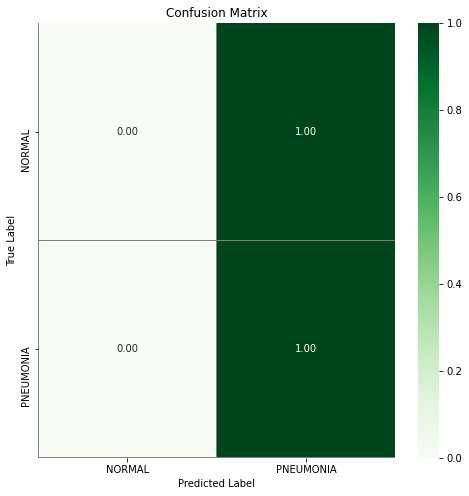

In [ ]:
model_evaluate(model_2, history)

Looking at the results it looks like model 2's accuracy is much reduced (62%) with 100% false positive rate,  suggesting that the additions I made to the CNN architecture were actually deterimental to the performance of the model.

### **Balancing data and early stop callback implementation**

Looking at the confusion matrices for all the models developed so far, it is clear that all three CNN models have trouble distinguising the healthy (normal) x-rays from pneumonia x-rays, thus causing a very high false positive rate. As seen above, the training data that these models are using is greatly imbalanced having about 3 times more pneumonia x-rays than normal x-rays. Imbalances in the number of images in each class will invariably affect how the model performs as it bias the model towards the more abundant class. Because of this, I reasoned that if the classes are more balanced, the models will perform better. To balance the data, I first calculated weight of each class of x-ray images by dividing the number of x-rays images in each class by the total number of images. This show how much one class is represented versus the other. Then I assigned the weight of the pneumonia class to the value of weight that I calculated the normal class to have and vice-versa to equally penalize under or over-represented classes in the training set.  

In addition, a problem with training neural networks is in the choice of the number of training epochs to use. Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. In the previous models I had choosen to use 10 epochs, which was a rather arbitrary choice, based on previous experiences. But since the models that I have created thus far could use some improvement, I decided to use an automated method, called early stopping, that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. 

Using these alterations, I went back and used the same CNN architecture as before and tested if balancing the data and adding the early stopping callback would be sufficient to improve the models.

In [ ]:
pneumonia = len(os.listdir(os.path.join(train_folder, "PNEUMONIA")))
normal = len(os.listdir(os.path.join(train_folder, "NORMAL")))
pneumonia, normal


(3875, 1341)

In [ ]:
class_1 = pneumonia /(normal + pneumonia)
class_2 = normal/(normal + pneumonia)

class_weight = {0: class_1, 1: class_2}
print(f"Weight for class 0: {class_1:.2f}")
print(f"Weight for class 1: {class_2:.2f}")

#//stackoverflow.com/questions/53860734/adding-class-weights-for-imbalanced-dataset-in-convolutional-neural-network

Weight for class 0: 0.74
Weight for class 1: 0.26


In [ ]:
# Set up early stopping and learning rate reduction
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3)
lr_redox = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
callbacks = [early_stop, lr_redox]

#### **Baseline Model with balanced data**

In [ ]:
#initialising the CNN 
Balance_model = models.Sequential()

#Add a convolution layer with 32 kernels of 3X3 shape padding of same and activation Relu
Balance_model.add(Conv2D(32, (3, 3),padding="same", activation='relu',
                    
                    input_shape=(64,  64, 3)
                    ))
# Add  Max Pooling layer
Balance_model.add(MaxPooling2D((2, 2)))

#Add a convolution layer with 64 kernels of 3X3 shape padding of same and activation Relu
Balance_model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
Balance_model.add(MaxPooling2D(3, 3))

Balance_model.add(Conv2D(64, (3, 3), padding="same",  activation='relu'))
Balance_model.add(MaxPooling2D((2, 2)))


#Flatting the layer before fully connected layers
Balance_model.add(Flatten())

#Add a fully connected layer with 512 neurons

Balance_model.add(Dense(124, activation='relu'))
Balance_model.add(Dense(1, activation='sigmoid'))
Balance_model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

Balance_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)             

In [ ]:
history = Balance_model.fit_generator(train_set,
                       epochs= 20,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set,
                       class_weight=class_weight,
                   callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
163/163 [==============================] - 52s 314ms/step - loss: 0.2925 - acc: 0.6300 - val_loss: 0.7149 - val_acc: 0.4896
Epoch 2/20
163/163 [==============================] - 51s 314ms/step - loss: 0.2954 - acc: 0.6812 - val_loss: 0.6841 - val_acc: 0.5000
Epoch 3/20
163/163 [==============================] - 51s 312ms/step - loss: 0.2465 - acc: 0.7034 - val_loss: 0.5409 - val_acc: 0.6875
Epoch 4/20
163/163 [==============================] - 51s 312ms/step - loss: 0.2192 - acc: 0.7391 - val_loss: 0.6152 - val_acc: 0.5833
Epoch 5/20
163/163 [==============================] - 51s 313ms/step - loss: 0.1864 - acc: 0.7868 - val_loss: 0.5427 - val_acc: 0.6771
Epoch 6/20
163/163 [==============================] - 52s 318ms/step - loss: 0.1961 - acc: 0.7887 - val_loss: 0.3707 - val_acc: 0.8438
Epoch 7/20
163/163 [==============================] 

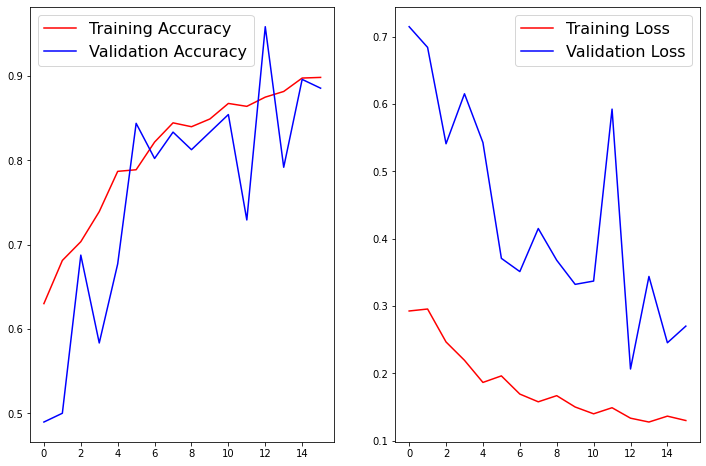

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.87      0.74      0.80       188
   PNEUMONIA       0.86      0.93      0.89       312

    accuracy                           0.86       500
   macro avg       0.86      0.84      0.85       500
weighted avg       0.86      0.86      0.86       500



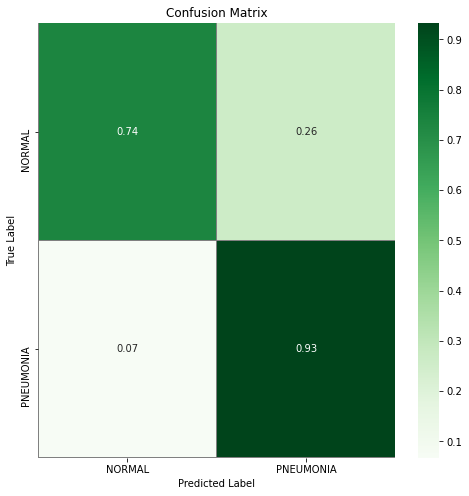

In [ ]:
model_evaluate(Balance_model, history)

Balancing the data and implementing the early stop call back definitly improved the baseline model. It's accuracy is only mildly increased (86% from 85%), but the false positive rate is reduced to 26%, suggesting that the imbalance in the original data as in fact introducing bias in the model.

####  **Model 1 with balanced data**

In [ ]:
#initialising the CNN 
Balance_model_1 = models.Sequential()

#Add a convolution layer with 32 kernels of 3X3 shape padding of same and activation Relu
Balance_model_1.add(Conv2D(32, (3,3 ),padding="same", activation='relu',                
                    input_shape=(64,  64, 3)))
Balance_model_1.add(layers.MaxPooling2D((2, 2)))
Balance_model_1.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
# Add  Max Pooling layer
Balance_model_1.add(MaxPooling2D((2, 2)))


#Add a convolution layer with 128 kernels of 3X3 shape padding of same and activation Relu
Balance_model_1.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
Balance_model_1.add(MaxPooling2D(2, 2))

Balance_model_1.add(Conv2D(128, (3, 3), padding="same",  activation='relu'))
Balance_model_1.add(MaxPooling2D((2, 2)))



#Flatting the layer before fully connected layers
Balance_model_1.add(Flatten())
#Balance_model_1.add(Dense(64, activation='relu'))
Balance_model_1.add(Dense(128, activation='relu'))
Balance_model_1.add(Dense(256, activation='relu'))
Balance_model_1.add(Dense(512, activation='relu'))

Balance_model_1.add(Dense(1, activation='sigmoid'))

Balance_model_1.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

Balance_model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)        

In [ ]:

history = Balance_model_1.fit_generator(train_set,
                       epochs= 20,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set,
                       class_weight=class_weight,
                   callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 53s 318ms/step - loss: 0.6178 - acc: 0.5159 - val_loss: 0.6956 - val_acc: 0.5208
Epoch 2/20
163/163 [==============================] - 51s 315ms/step - loss: 0.3128 - acc: 0.6609 - val_loss: 0.7087 - val_acc: 0.5208
Epoch 3/20
163/163 [==============================] - 52s 317ms/step - loss: 0.3110 - acc: 0.6695 - val_loss: 0.7533 - val_acc: 0.5104
Epoch 4/20
163/163 [==============================] - 51s 315ms/step - loss: 0.2717 - acc: 0.7061 - val_loss: 0.7395 - val_acc: 0.5833


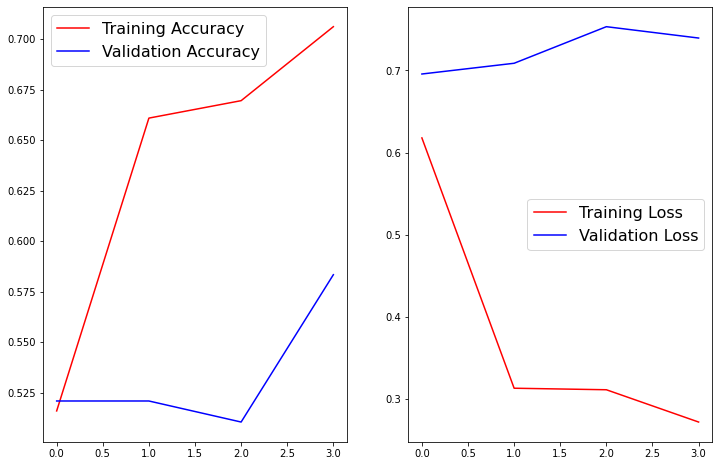

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.75      0.70      0.73       188
   PNEUMONIA       0.83      0.86      0.84       312

    accuracy                           0.80       500
   macro avg       0.79      0.78      0.79       500
weighted avg       0.80      0.80      0.80       500



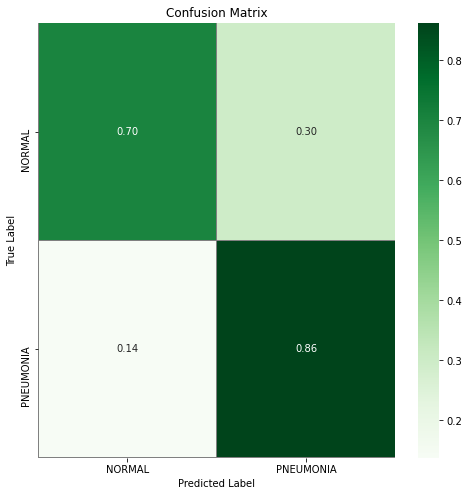

In [ ]:
model_evaluate(Balance_model_1, history)


Much like what happened with the Baseline Model, Model 1's accuracy was also not greatly affected by these alterations. However, its ability to correctly predict normal x-rays is much higher (from 48% with the original data to 70% with the balanced data). Unfortunatly, the increase in correct detection of normal x-rays came at the cost of reducing the amount of correct pneumonia recalls (from 99% with the original data to 86%). 

#### **Model 2 with balanced data**

In [ ]:
#initialising the CNN 
Balance_model_2 = models.Sequential()

#Add a convolution layer with 32 kernels of 3X3 shape padding of same and activation Relu
Balance_model_2.add(Conv2D(32, (3,3 ),padding="same", activation='relu',                
                    input_shape=(64,  64, 3)))
Balance_model_2.add(layers.MaxPooling2D((2, 2)))
Balance_model_2.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
# Add  Max Pooling layer
Balance_model_2.add(MaxPooling2D((2, 2)))


#Add a convolution layer with 128 kernels of 3X3 shape padding of same and activation Relu
Balance_model_2.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
Balance_model_2.add(MaxPooling2D(2, 2))

Balance_model_2.add(Conv2D(128, (3, 3), padding="same",  activation='relu'))
Balance_model_2.add(MaxPooling2D((2, 2)))


Balance_model_2.add(Dropout(0.2))
#Flatting the layer before fully connected layers
Balance_model_2.add(Flatten())
#Add a fully connected layers
#Balance_model_2.add(Dense(64, activation='relu'))
Balance_model_2.add(Dense(128, activation='relu'))
Balance_model_2.add(Dropout(0.2))
Balance_model_2.add(Dense(128, activation='relu'))
Balance_model_2.add(Dense(512, activation='relu'))
Balance_model_2.add(Dense(1, activation='sigmoid'))

Balance_model_2.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

Balance_model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
history = Balance_model_2.fit_generator(train_set,
                       epochs= 20,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set,
                       class_weight=class_weight,
                   callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 51s 316ms/step - loss: 0.2222 - acc: 0.6660 - val_loss: 0.7169 - val_acc: 0.5625
Epoch 2/20
163/163 [==============================] - 51s 312ms/step - loss: 0.2234 - acc: 0.7383 - val_loss: 0.5116 - val_acc: 0.8333
Epoch 3/20
163/163 [==============================] - 51s 310ms/step - loss: 0.2050 - acc: 0.7270 - val_loss: 0.5093 - val_acc: 0.8125
Epoch 4/20
163/163 [==============================] - 51s 315ms/step - loss: 0.1964 - acc: 0.7736 - val_loss: 1.6616 - val_acc: 0.4792
Epoch 5/20
163/163 [==============================] - 51s 310ms/step - loss: 0.1891 - acc: 0.7619 - val_loss: 0.5984 - val_acc: 0.5833
Epoch 6/20
163/163 [==============================] - 51s 315ms/step - loss: 0.1791 - acc: 0.7985 - val_loss: 0.4388 - val_acc: 0.7812
Epoch 7/20
163/163 [==============================] - 51s 310ms/step - loss: 0.1616 - acc: 0.7972 - val_loss: 0.4418 - val_acc: 0.7292
Epoch 8/20
163/163 [==============================] - 5

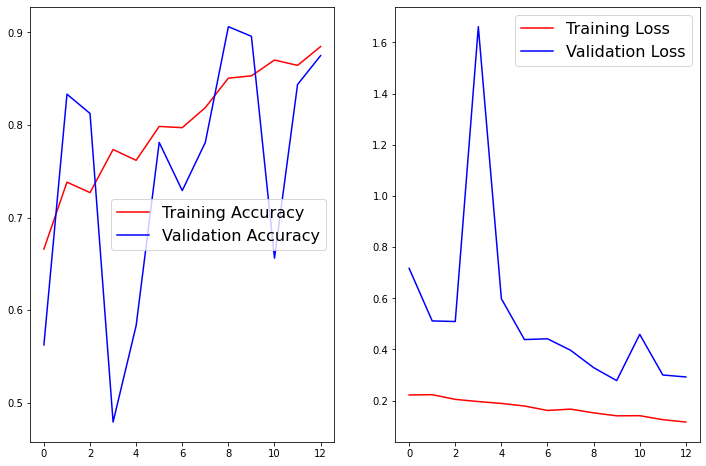

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.84      0.81      0.82       188
   PNEUMONIA       0.89      0.91      0.90       312

    accuracy                           0.87       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.87      0.87      0.87       500



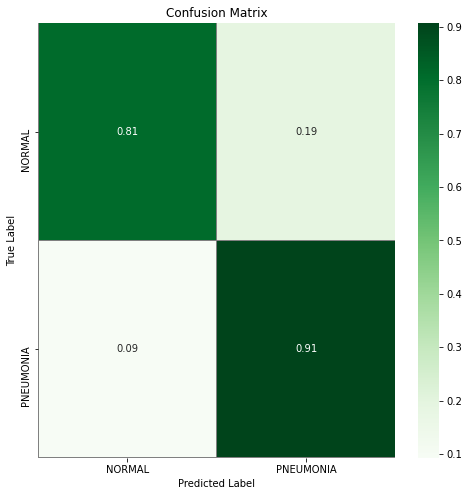

In [ ]:
model_evaluate(Balance_model_2, history)

Model 2, which with the original data had a really poor performance, with the balanced data and early stop callback performs much better. In fact, model 2's accuracy using these settings is the highest of all CNN architectures that I have constructed here (87%) and it has the best performance at recalling correctly normal x-rays while still maintaining a high recall performance for pneumonia x-rays (91%). 

#### **VGG16 model with balanced data**

In addition to the models that I have constructed above, I also implemented the VGG16 architecture to see if it would result is a model with higher performance. VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))
model_vgg16.trainable = False
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
vgg_model = models.Sequential()
vgg_model.add(model_vgg16)
vgg_model.add(layers.Flatten())
#vgg_model.add(layers.Dense(64, activation='relu'))
vgg_model.add(Dropout(0.2))
vgg_model.add(layers.Dense(128, activation='relu'))
#vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))
vgg_model.compile(loss='binary_crossentropy',
                optimizer='RMSProp',
                metrics=['acc'])

In [ ]:
history = vgg_model.fit_generator(train_set,
                       epochs= 20,
                       steps_per_epoch = train_size//BATCH_SIZE,
                       validation_steps = val_size//BATCH_SIZE,
                       validation_data= val_set,
                       class_weight=class_weight,
                   callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 53s 320ms/step - loss: 0.2451 - acc: 0.6921 - val_loss: 0.2671 - val_acc: 0.9167
Epoch 2/20
163/163 [==============================] - 52s 317ms/step - loss: 0.1522 - acc: 0.8317 - val_loss: 0.4300 - val_acc: 0.8125
Epoch 3/20
163/163 [==============================] - 52s 317ms/step - loss: 0.1373 - acc: 0.8719 - val_loss: 0.3038 - val_acc: 0.8854
Epoch 4/20
163/163 [==============================] - 51s 316ms/step - loss: 0.1219 - acc: 0.8687 - val_loss: 0.1936 - val_acc: 0.9479
Epoch 5/20
163/163 [==============================] - 50s 309ms/step - loss: 0.1192 - acc: 0.8731 - val_loss: 0.2481 - val_acc: 0.9271
Epoch 6/20
163/163 [==============================] - 50s 310ms/step - loss: 0.1191 - acc: 0.8875 - val_loss: 0.1952 - val_acc: 0.9479
Epoch 7/20
163/163 [==============================] - 50s 307ms/step - loss: 0.1115 - acc: 0.8907 - val_loss: 0.1880 - val_acc: 0.9479
Epoch 8/20
163/163 [==============================] - 5

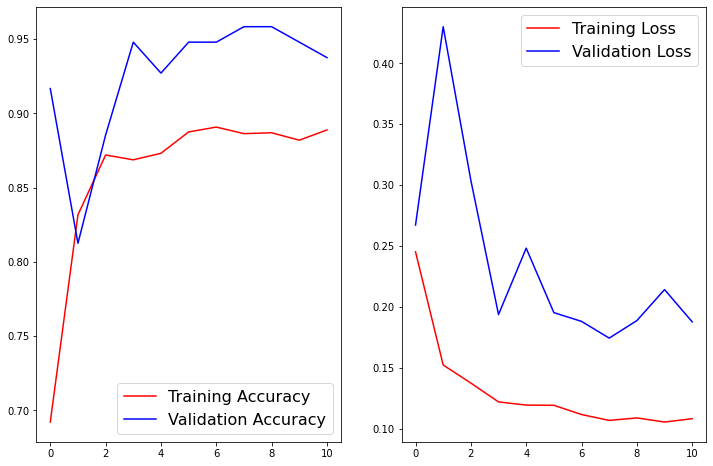

************************************************************
Classification Report
************************************************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.81      0.86      0.83       188
   PNEUMONIA       0.91      0.88      0.89       312

    accuracy                           0.87       500
   macro avg       0.86      0.87      0.86       500
weighted avg       0.87      0.87      0.87       500



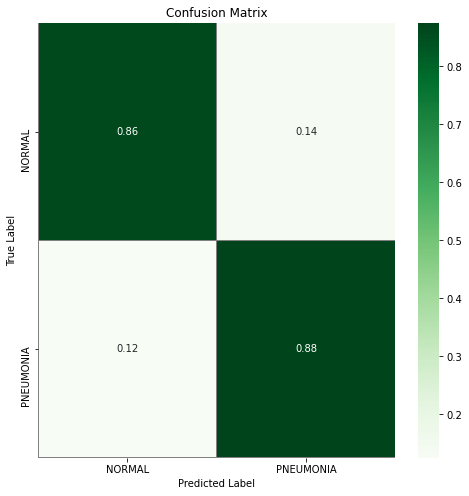

In [ ]:
model_evaluate(vgg_model, history)

Looking at the results it is clear that VGG16 is a great model to accuratly predict chest x-rays. Similar to what I obtained with my CNN architecture of model 2, VGG16 also shows a 87% accuracy and it can also distinguish very well between normal and pneumonia x-rays.

## VI. Model Analysis


### **Saving the Model**
Looking at all the models, it seems that the best CNN model that I have built is Model 2 run with balanced data and the early stop callback, which is able to predict 91% of pneumonia  while still able to predict a high proportion of normal x-rays (81%).

In [ ]:
model2_path  = "/content/drive/MyDrive/model2.hd5"
model2_path

'/content/drive/MyDrive/model2.hd5'

In [ ]:
#Balance_model_2.save(model2_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model2.hd5/assets


In [ ]:
# Reload model
best_model = models.load_model(model2_path)

While this has one of the best accuracy of the models that I have built, looking at the accuracy and loss curves it is obvious that the model can be improved to become more robust as there is a high degree of variability both in loss and in accuracy through the different epochs. Fine-tunning of the CNN architecture including fine-tunning of the hyperparameters within each layer of the neural network are likely to yield an improved and more robust model.

### **Lime**
To get a sense into what features of the x-ray images were contributing for the improper diagnosis of normal x-rays as pneumonia, I used the Lime package to depict the features that the model found most important in making its predictions. 

In [ ]:

test = test_val_datagen.flow_from_directory(test_folder,
                                                     target_size=IMG_SIZE,
                                                     subset='training',
                                                     batch_size=500,
                                                     classes = ["NORMAL", "PNEUMONIA"],
                                                     class_mode='binary',
                                                shuffle=False
                                               )

Found 500 images belonging to 2 classes.


In [ ]:
x_test, y_test = next(test)

True Class: 0.0
Predicted Class: 1


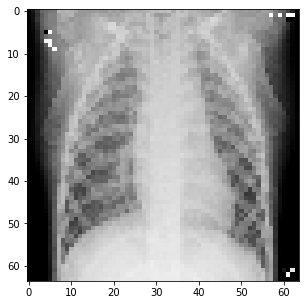

In [ ]:
# Get image and label for an accurate normal prediction
label = y_test[90]
img = x_test[90]

# Get model pred
pred =best_model.predict(np.array([img]))
pred_class = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label)
print('Predicted Class:', pred_class)
plt.imshow(img)
plt.show()

In [ ]:
explainer = lime_image.LimeImageExplainer()


label:  0.0 prediction: 0


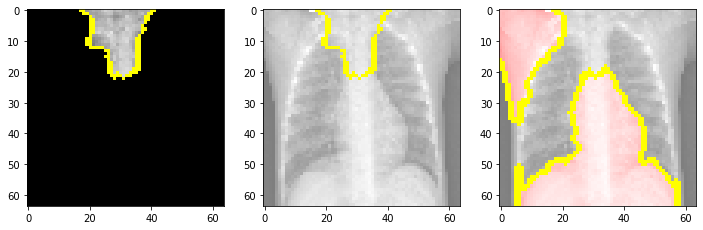

In [ ]:
plt.rcParams['figure.figsize'] = [12, 5]
def mask_temp_1(index):
  label = y_test[index]
  img = x_test[index]

  pred = best_model.predict(np.array([img]))
  pred_class = int(pred.round())

  explanation = explainer.explain_instance(img, best_model.predict, top_labels=15, hide_color=None, num_samples=1000)

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(mark_boundaries(temp, mask))


  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
  ax[2].imshow(mark_boundaries(temp / 2 + 0.5, mask))
  
  
  #temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  #ax[3].imshow(mark_boundaries(temp / 2 + 0.5, mask))



  print("label: ", label, "prediction:", pred_class)

mask_temp_1(2)


label:  0.0 prediction: 1


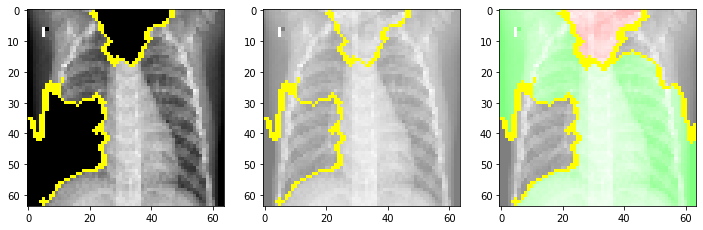

In [ ]:
mask_temp_1(6)

The images shown displays the features that the model found the most important in green and the ones found to be less important in red. From this imag we can see that the CNN model picked up a large portion of the diaphragm and the sternum as key features in making its incorrect prediction, suggesting that the high intensity pixels coming from these areas may be adding noise to the model. Taking this into consideration, additional pre-processing methods that can remove or supress the intensity of pixels coming from the diaphragm and sternum areas could also be valuable in improving this model for future clinical use.

## **VII.Conclusions**

In conclusion, I was able to develop a deep learning model using convolutional neural network that, albeit not perfect, can accuratly diagnose pneumonia from chest x-ray images. Through the process of building and analysing this model we learned the following:

1) Chest x-ray images can be used to develop AI-based diagnostic models.

2) Chest X-rays are a good tool for the diagnosis of pneumonia.

3) The diaphragm and sternum areas are a source of noise that affects the ability of model to correctly diagnose patients.

These are important information when implementing this or other AI-based tools for pneumonia diagnoses in the clinic. Therefore, for the implementation of this tool in a clinical setting I would recomend it to be implemented as follows:

* Develop a pre-processing tool that removes the noise coming from the diaphragm and sternum areas which is done automatically as part of the x-ray processing.

* Implement the AI model automatically once the x-ray image is generated and processed as a first step in the diagnosis of pneumonia to help inform the radiologist that interprets the x-ray.

This would help speed up the x-ray analysis and increase efficiency within the healthcare system but still require a doctor to make a final diagnosis based on the diagnosis done by the AI model, the doctor's experience and the patient's symptoms. 




